In [1]:
import pandas as pd
import utils
import warnings
import os
import skimage.util
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
orf_genesets = [
    ["SLC39A1", "ZBTB16"],
    ["SARS2", "ECH1", "DGUOK", "MRPS2", "LDHAL6B", "UQCRFS1"],
    ["MYT1", "LZTS2", "CHRM4", "GPR176", "TSC22D1"],
    ["SPDL1", "PAFAH1B1", "NDEL1", "NDE1", "HOOK2", "HOOK1"],
    ["MYT1", "INSYN1", "RNF41"],
    ["ZFP36L1", "PIK3R3", "NRBP1", "INSYN1", "HOXC8", "RAB40C", "RAB40B"]
]

crispr_genesets = [
    ["FOXO3", "TGFB1"],
    ["SARS2", "ECH1", "PVR", "LAIR1", "SLC1A5", "UQCRFS1"],
    ["MYT1", "CHRM4", "GPR176", "TSC22D1"],
    ["PIK3R3", "ZFP36L1", "HOXC8", "NRBP1", "RAB40B"]
]

channels = ["DNA", "RNA", "Mito", "ER", "AGP"]

overwrite = False

In [3]:
orf_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol", "Metadata_pert_type"],
)

orf_profiles_with_feature_names_df = pd.read_parquet(
    "../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet"
).merge(orf_metadata_df, on="Metadata_JCP2022", how="inner")

orf_profiles_metadata_df = utils.get_metadata(orf_profiles_with_feature_names_df)

orf_profiles_metadata_df.head()

Metadata_Source Metadata_Plate Metadata_Well Metadata_JCP2022  \
0        source_4     BR00117035           A01   JCP2022_905588   
1        source_4     BR00117036           A01   JCP2022_905588   
2        source_4     BR00121558           A01   JCP2022_905588   
3        source_4     BR00121559           A01   JCP2022_905588   
4        source_4     BR00121560           A01   JCP2022_905588   

  Metadata_Symbol Metadata_pert_type  
0            CDK9                trt  
1            CDK9                trt  
2            CDK9                trt  
3            CDK9                trt  
4            CDK9                trt

In [4]:
crispr_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol"],
)

crispr_controls_df = pd.DataFrame(
    {
        "Metadata_JCP2022": ["JCP2022_805264", "JCP2022_800001", "JCP2022_800002"],
        "Metadata_pert_type": ["poscon", "negcon", "negcon"],
    },
    index=[0, 1, 2],
)

crispr_profiles_with_feature_names_df = (
    pd.read_parquet("../profiles/profiles_wellpos_cc_var_mad_outlier_crispr.parquet")
    .merge(crispr_metadata_df, on="Metadata_JCP2022", how="inner")
    .merge(crispr_controls_df, on="Metadata_JCP2022", how="left")
    .fillna(value={"Metadata_pert_type": "trt"})
)

crispr_profiles_metadata_df = utils.get_metadata(crispr_profiles_with_feature_names_df)

crispr_profiles_metadata_df.head()

Metadata_Source Metadata_Plate Metadata_Well Metadata_JCP2022  \
0       source_13   CP-CC9-R1-01           A02   JCP2022_800002   
1       source_13   CP-CC9-R1-01           L23   JCP2022_800002   
2       source_13   CP-CC9-R1-01           I23   JCP2022_800002   
3       source_13   CP-CC9-R1-01           J02   JCP2022_800002   
4       source_13   CP-CC9-R1-01           O23   JCP2022_800002   

  Metadata_Symbol Metadata_pert_type  
0   non-targeting             negcon  
1   non-targeting             negcon  
2   non-targeting             negcon  
3   non-targeting             negcon  
4   non-targeting             negcon

In [5]:
plate_df = pd.read_csv("../datasets/metadata/plate.csv.gz", usecols=["Metadata_Batch", "Metadata_Plate"])

In [6]:
df = pd.DataFrame()

for geneset in orf_genesets:
    treatment_metadata_df = orf_profiles_metadata_df.query(
        "Metadata_Symbol in @geneset"
    ).sample(n=1, random_state=12527)
    plates_with_genes = list(np.unique(treatment_metadata_df.Metadata_Plate.to_list()))
    negative_control_metadata_df = orf_profiles_metadata_df.query(
        "Metadata_pert_type == 'negcon' and Metadata_Plate in @plates_with_genes"
    ).sample(n=1, random_state=12527)

    orf_df = pd.concat(
        [
            treatment_metadata_df,
            negative_control_metadata_df
        ],
        ignore_index=True,
    )

    orf_df = orf_df.assign(cluster='-'.join(geneset), modality="ORF")

    orf_df = orf_df.merge(plate_df, on="Metadata_Plate", how="left")

    df = pd.concat(
        [
            df,
            orf_df
        ],
        ignore_index=True
    )

In [7]:
for geneset in crispr_genesets:
    treatment_metadata_df = crispr_profiles_metadata_df.query(
        "Metadata_Symbol in @geneset"
    ).sample(n=1, random_state=12527)
    plates_with_genes = list(np.unique(treatment_metadata_df.Metadata_Plate.to_list()))
    negative_control_metadata_df = crispr_profiles_metadata_df.query(
        "Metadata_pert_type == 'negcon' and Metadata_Plate in @plates_with_genes"
    ).sample(n=1, random_state=12527)

    crispr_df = pd.concat(
        [
            treatment_metadata_df,
            negative_control_metadata_df
        ],
        ignore_index=True,
    )

    crispr_df = crispr_df.assign(cluster='-'.join(geneset), modality="CRISPR")

    crispr_df = crispr_df.merge(plate_df, on="Metadata_Plate", how="left")

    df = pd.concat(
        [
            df,
            crispr_df
        ],
        ignore_index=True
    )

In [8]:
df = df.drop_duplicates(subset=["Metadata_JCP2022"])

temp_df = pd.DataFrame()

for channel in channels:
    temp_df = pd.concat(
        [
            temp_df,
            df.assign(channel=channel)
        ],
        ignore_index=True,
    )

df = temp_df.copy()

In [9]:
if overwrite:
    os.system("rm -rf cluster_images")
    os.system("mkdir cluster_images")

    for jcpid in df.Metadata_JCP2022.unique():
        os.system(f"mkdir cluster_images/{jcpid}")
    utils.download_images(df, folder="cluster_images")

Create Montage

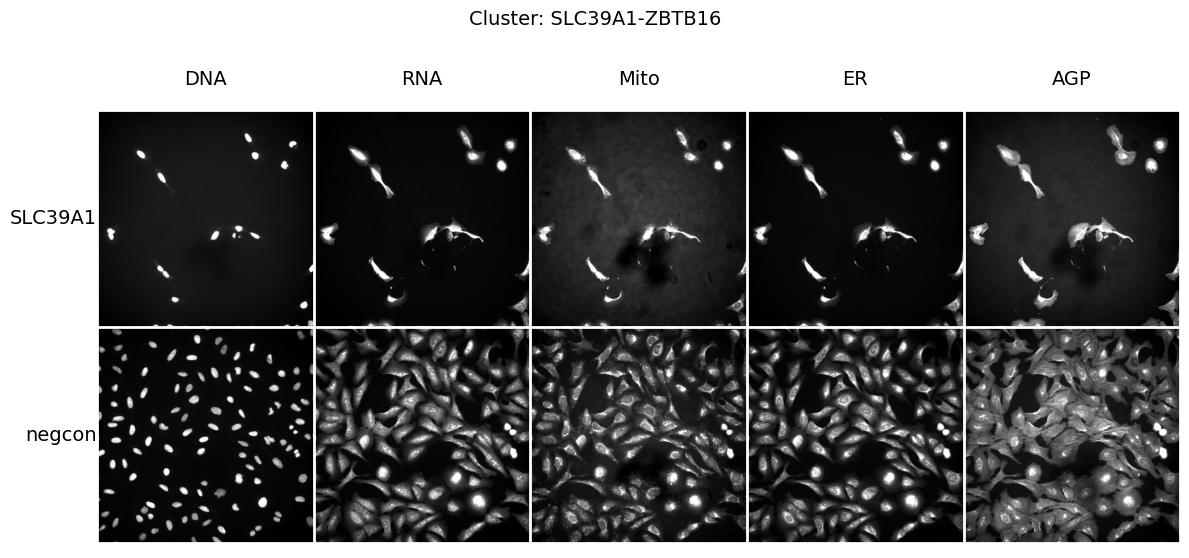

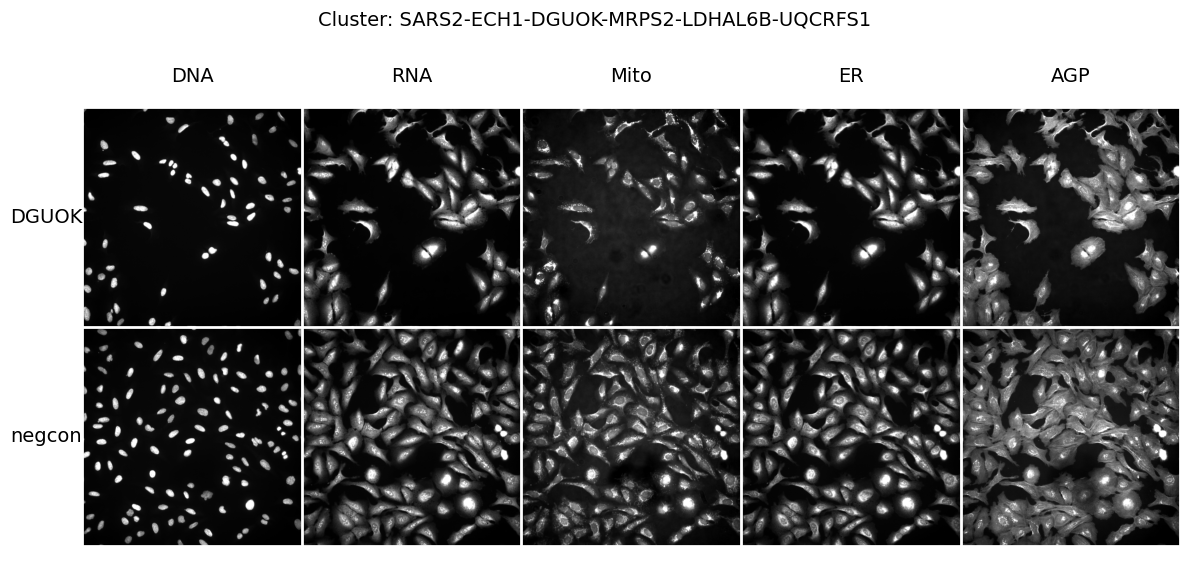

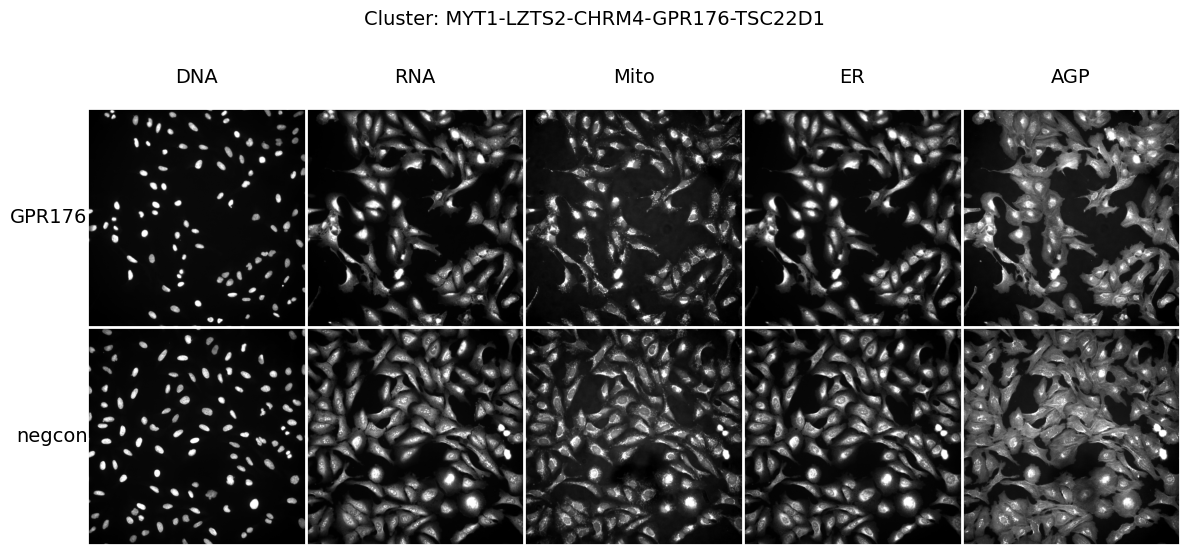

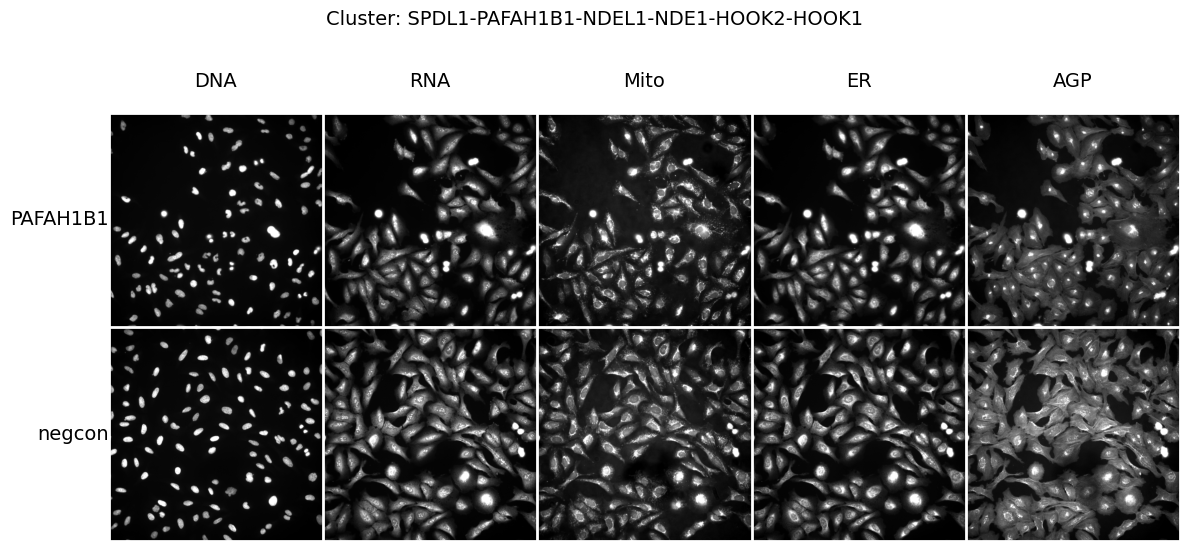

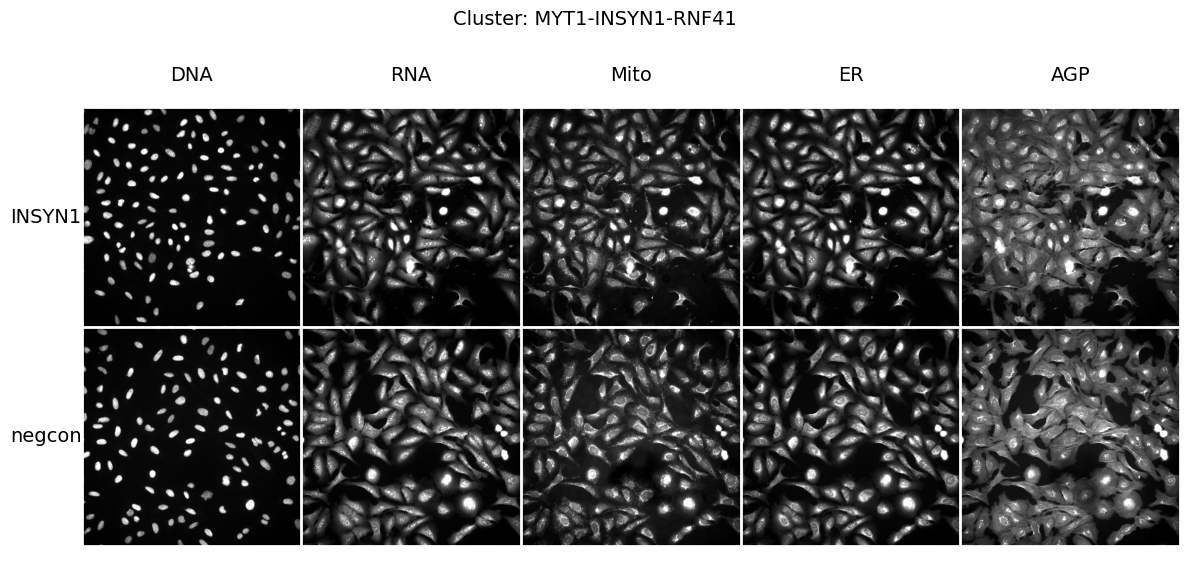

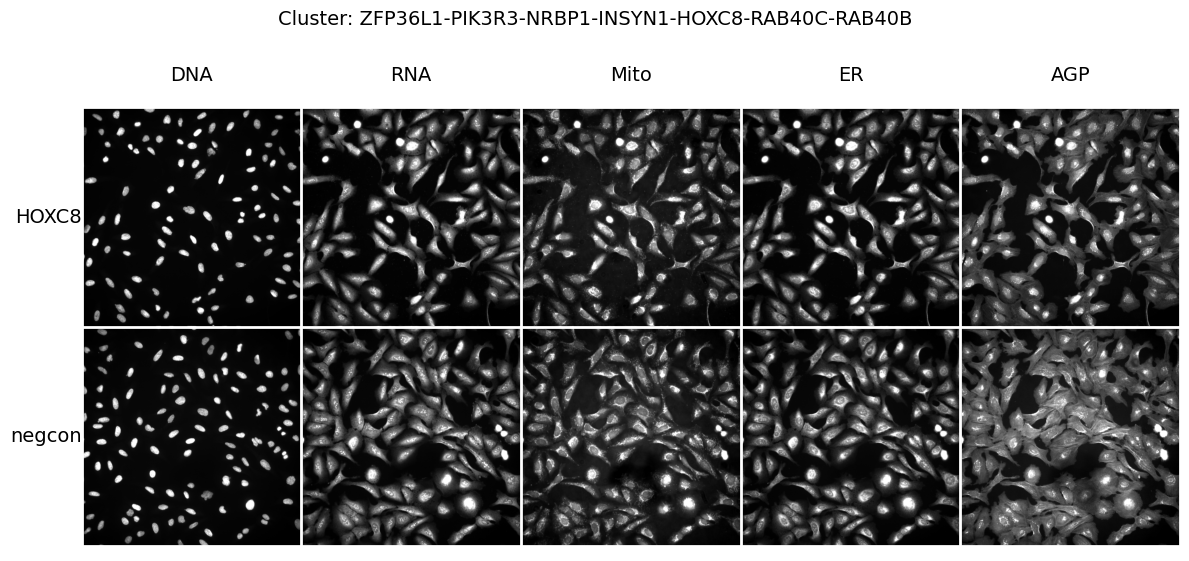

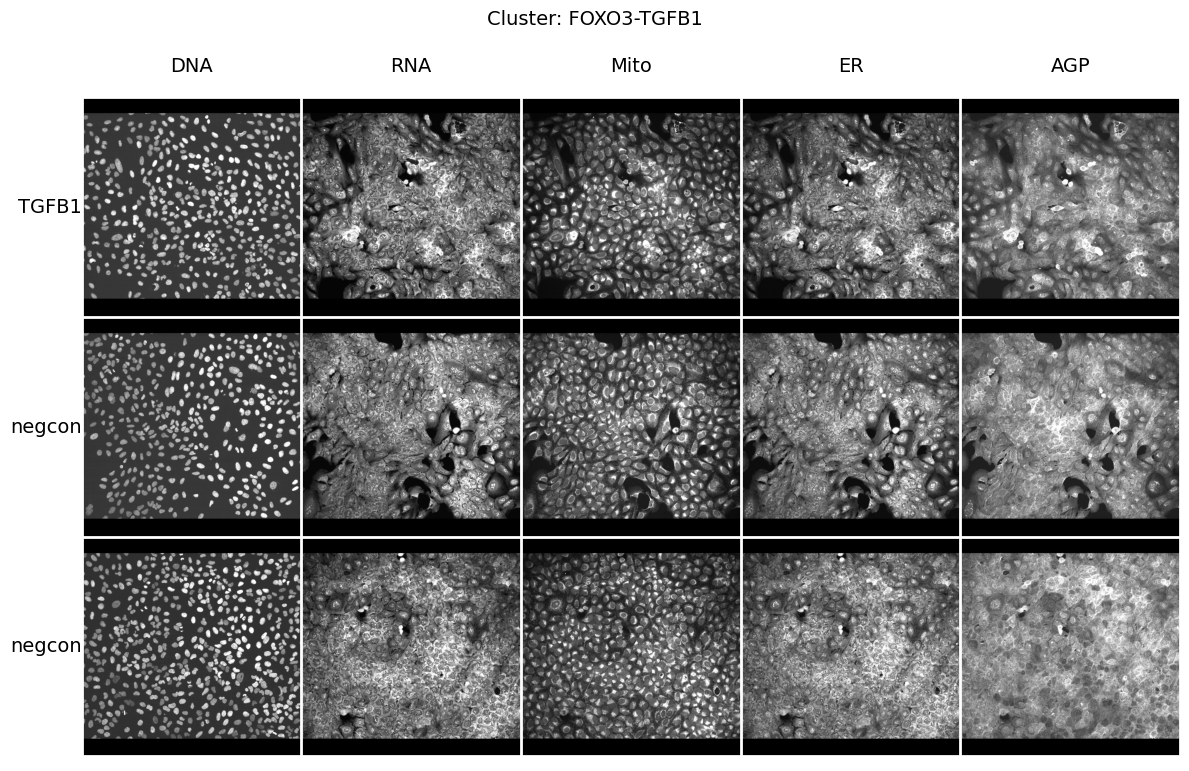

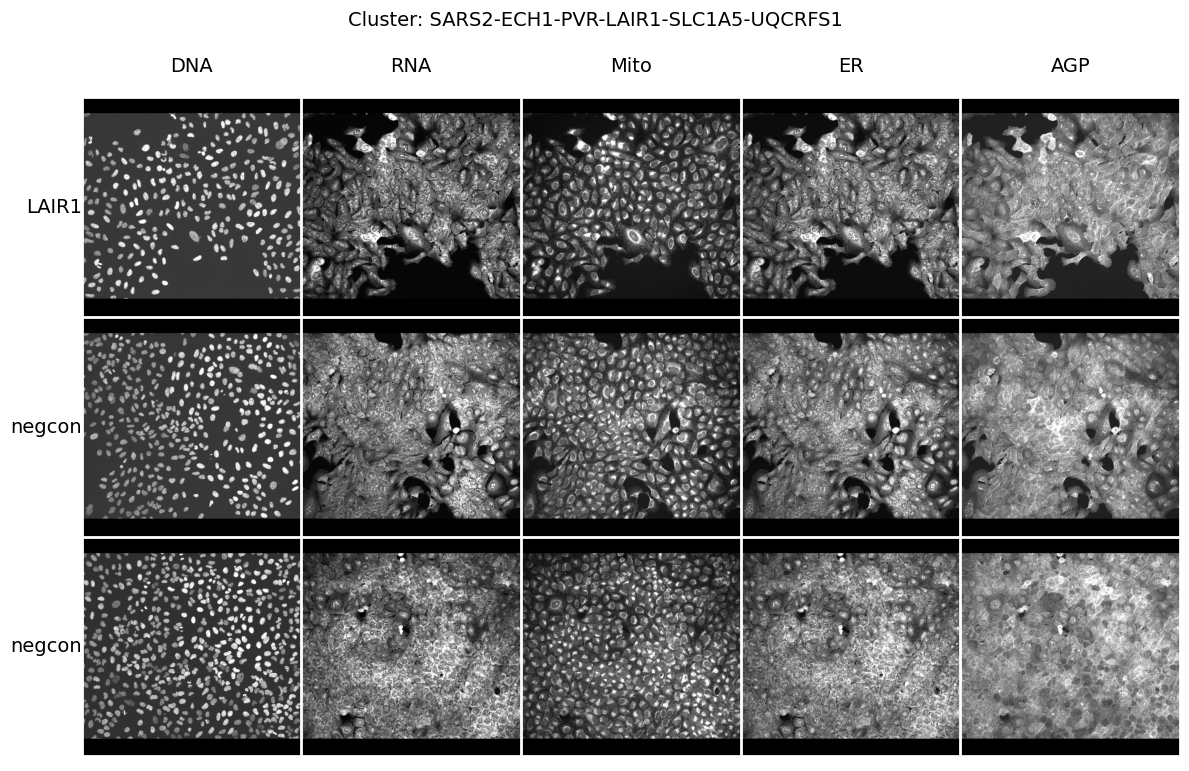

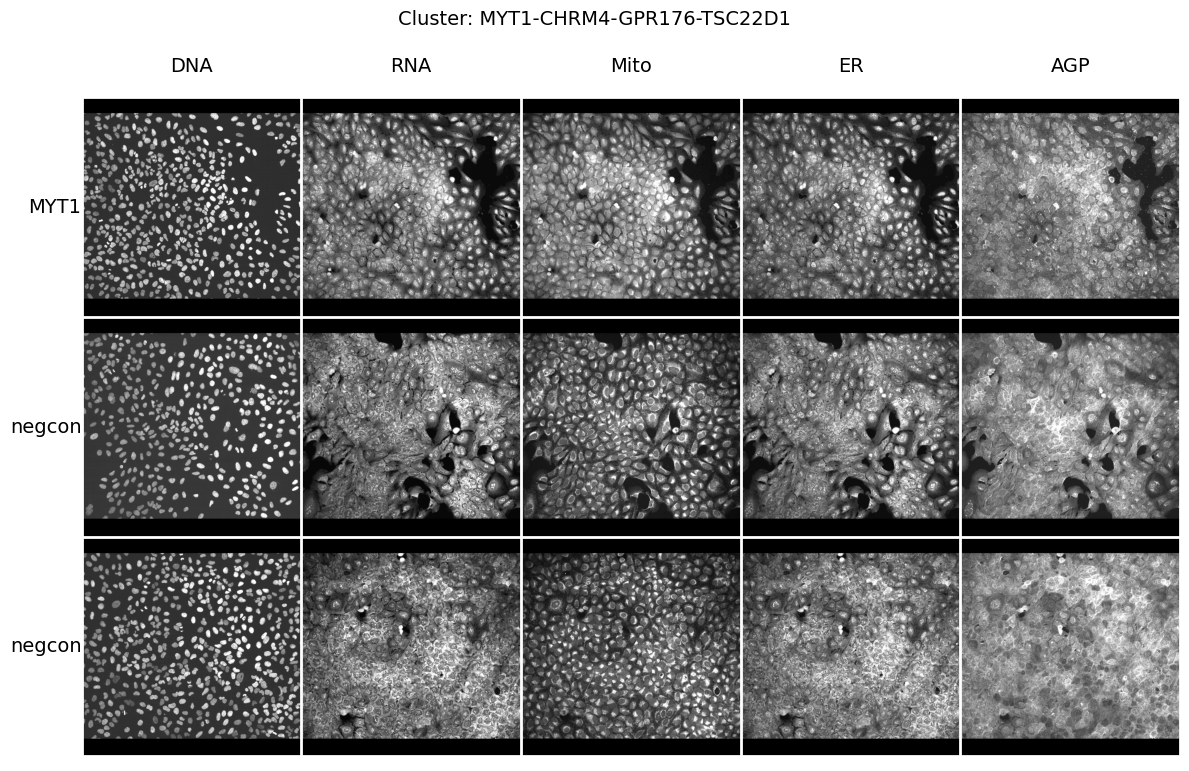

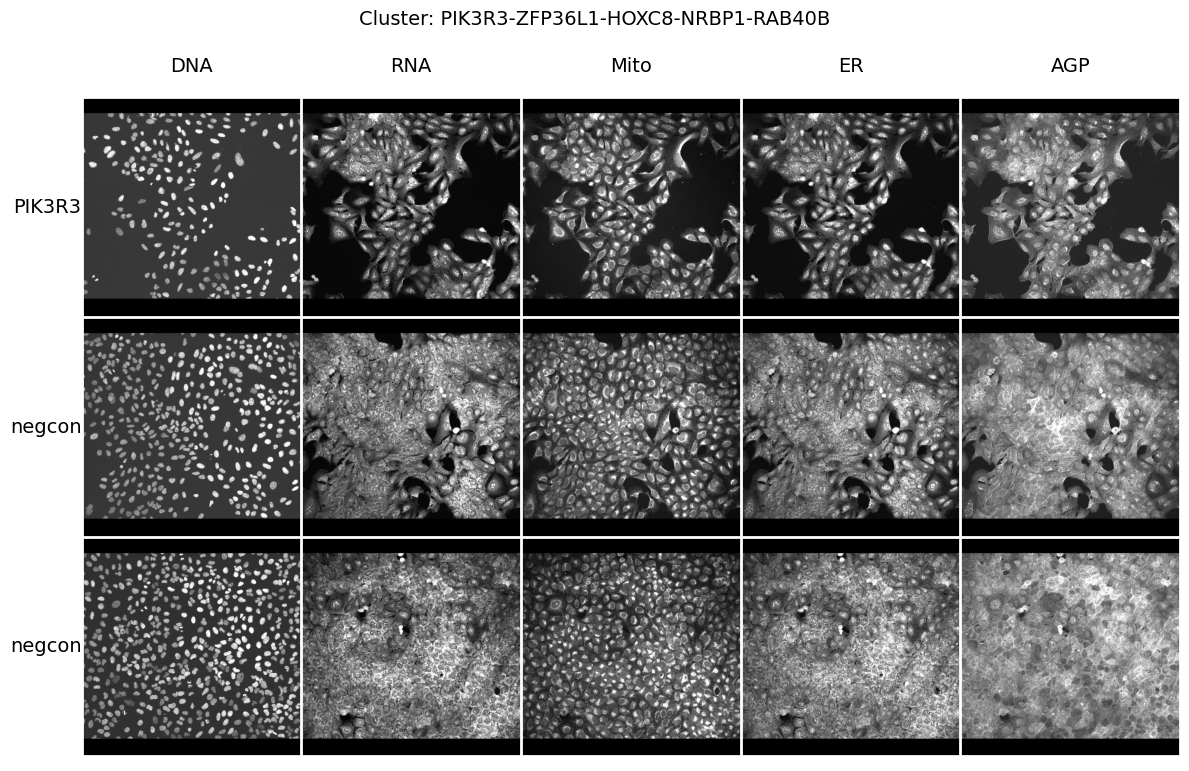

In [10]:
col_labels = channels

for gene in df.query("Metadata_pert_type == 'trt'").Metadata_Symbol.unique():
    images = []
    temp_df = df.query("Metadata_Symbol == @gene").drop_duplicates(
        subset=["Metadata_JCP2022"]
    )
    cluster = temp_df.cluster.values[0]
    jcpid = temp_df.Metadata_JCP2022.to_list()
    modality = temp_df.modality.values[0]
    negcons = df.query(
        "Metadata_pert_type == 'negcon' & modality == @modality"
    ).drop_duplicates(subset=["Metadata_JCP2022"]).Metadata_JCP2022.to_list()

    row_labels = [gene] + ["negcon" for i in range(len(negcons))]

    for perturbation in jcpid+negcons:
        for channel in channels:
            filename = f"cluster_images/{perturbation}/{perturbation}_{channel}.tiff"
            img = skimage.io.imread(filename)
            img = utils.standardize_image(img, target_size=(1080, 1080))
            img = utils.brighten_contrast_stretch(img, 1, 99)
            images.append(img)
    
    grid_shape = (len(jcpid)+len(negcons), len(channels))

    fig = utils.create_facet_grid_montage(
        images, row_labels, col_labels, grid_shape, title=f"Cluster: {cluster}"
    )

    # Display the figure
    plt.show()

    # Save the figure    
    fig.savefig(f"figures/facet_grid_montage_{cluster}.png", dpi=600, bbox_inches="tight")